In [1]:
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
summary_matrix = np.genfromtxt('causal_graphs/latest_sp500_return_summary_matrix_varlingam_lag_1.csv', delimiter=',', dtype=None, encoding=None)
G = nx.from_numpy_array(summary_matrix.T, create_using=nx.DiGraph)
# G = nx.read_adjlist('causal_graphs/latest_sp500_return_graph_pcmci_lag_1.txt', create_using=nx.DiGraph)
tickers = pd.read_csv('data/Cleaned_SP500_Data_latest_return.csv', delimiter=',', nrows=1).columns.to_list()
# print(tickers)
mapping = {i: tickers[i] for i in G.nodes()}
# print(G.nodes())
G = nx.relabel_nodes(G, mapping)
print(G)

DiGraph with 465 nodes and 10048 edges


In [3]:
# delete all self-loops
G_major = G.copy()
self_loops = list(nx.selfloop_edges(G_major))
G_major.remove_edges_from(self_loops)
print(G_major)

DiGraph with 465 nodes and 9997 edges


In [4]:
percentile_95 = np.percentile(summary_matrix, 95)
percentile_99 = np.percentile(summary_matrix, 99)
percentile_999 = np.percentile(summary_matrix, 99.9)
percentile_999

for u, v, data in list(G_major.edges(data=True)):
    if data.get('weight', 0) < percentile_999:
        G_major.remove_edge(u, v)

In [5]:
isolated_nodes = [node for node in G_major.nodes() if G_major.degree(node) == 0]
G_major.remove_nodes_from(isolated_nodes)
print(G_major)

DiGraph with 266 nodes and 217 edges


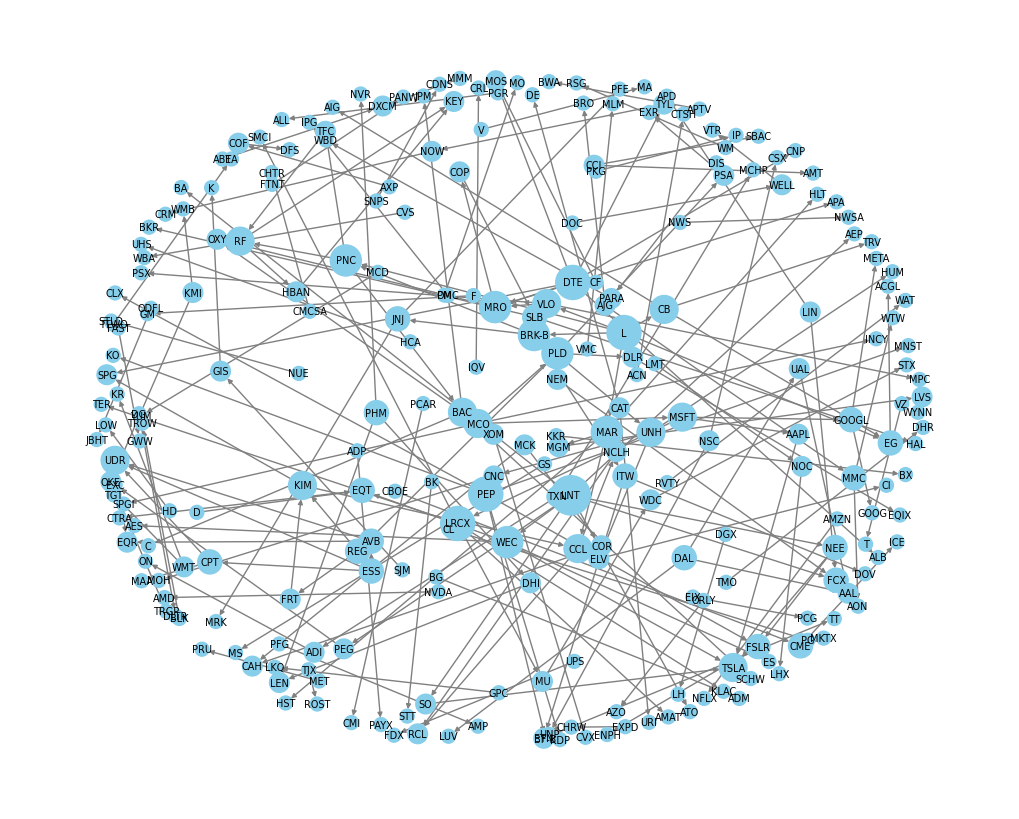

In [6]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(G_major, seed=42, k=0.5, iterations=100)
plt.figure(figsize=(10, 8))

degree_dict = {node: G_major.degree(node) for node in G_major.nodes()}
node_sizes = [degree_dict[node] * 100 for node in G_major.nodes()]
# Draw nodes, edges, and labels
nx.draw(G_major, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=7, font_color='black', edge_color='gray', arrows=True, arrowsize=7)

# Optionally, draw edge labels to show weights
# edge_labels = nx.get_edge_attributes(G_major, 'weight')
# nx.draw_networkx_edge_labels(G_major, pos, edge_labels=edge_labels)

# Display the plot
# plt.show()
# plt.tight_layout()
plt.savefig('./plots/sp500_major_causal_graph_varlingam_lag_1.pdf')

In [7]:
in_degrees = dict(G_major.in_degree())
stocks_with_most_causes = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes with the most causes:")
for node, degree in stocks_with_most_causes:
    sorted_causes = sorted(G_major.predecessors(node), key=lambda pred: G_major[pred][node]['weight'], reverse=True)
    print(f"Node {node}: {degree} causes {sorted_causes}")

Top 10 nodes with the most causes:
Node TSLA: 4 causes ['AAPL', 'WEC', 'SO', 'NEE']
Node UDR: 3 causes ['ESS', 'CPT', 'AVB']
Node FCX: 3 causes ['NEM', 'LNT', 'LIN']
Node RCL: 2 causes ['NCLH', 'CCL']
Node KIM: 2 causes ['FRT', 'REG']
Node CCL: 2 causes ['MAR', 'KIM']
Node LEN: 2 causes ['DHI', 'PHM']
Node FSLR: 2 causes ['NEE', 'PEP']
Node MRO: 2 causes ['DTE', 'VLO']
Node OXY: 2 causes ['XOM', 'MRO']


In [8]:
out_degrees = dict(G_major.out_degree())
stocks_with_most_effects = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes with the most effects:")
for node, degree in stocks_with_most_effects:
    sorted_effects = sorted(G_major.successors(node), key=lambda successor: G_major[node][successor]['weight'], reverse=True)
    print(f"Node {node}: {degree} effects {sorted_effects}")

Top 10 nodes with the most effects:
Node LNT: 8 effects ['PEG', 'SO', 'AEP', 'FCX', 'WEC', 'ATO', 'BA', 'NEE']
Node DTE: 6 effects ['MOS', 'ALB', 'MRO', 'TYL', 'CNP', 'SPG']
Node L: 6 effects ['CB', 'PNC', 'MAR', 'BRK-B', 'VLO', 'EG']
Node PEP: 6 effects ['KDP', 'MNST', 'CLX', 'KO', 'FSLR', 'BF-B']
Node LRCX: 5 effects ['AMAT', 'MU', 'KLAC', 'TER', 'SMCI']
Node BRK-B: 4 effects ['UNH', 'PNC', 'ITW', 'JNJ']
Node PLD: 4 effects ['DLR', 'PSA', 'REG', 'NEM']
Node MCO: 4 effects ['SPGI', 'PLD', 'MSFT', 'INCY']
Node WEC: 4 effects ['AES', 'ES', 'EQT', 'TSLA']
Node MAR: 4 effects ['CCL', 'HLT', 'MGM', 'HST']


In [9]:
total_degrees = dict(G_major.degree())
stocks_with_most_degrees = sorted(total_degrees.items(), key=lambda x: x[1], reverse=True)[:20]
print("Top 20 nodes with the most connections:")
for node, degree in stocks_with_most_degrees:
    sorted_causes = sorted(G_major.predecessors(node), key=lambda pred: G_major[pred][node]['weight'], reverse=True)
    sorted_effects = sorted(G_major.successors(node), key=lambda successor: G_major[node][successor]['weight'], reverse=True)
    print(f"{node} has {degree} connections, {G_major.in_degree(node)} causes: {sorted_causes}, and {G_major.out_degree(node)} effects: {sorted_effects}")
# print(total_degrees)
# node = 'KIM'
# print(f"{node} has {G_major.in_degree(node)} causes: {list(G_major.predecessors(node))}, and {G_major.out_degree(node)} effects: {list(G_major.successors(node))}")

Top 20 nodes with the most connections:
LNT has 8 connections, 0 causes: [], and 8 effects: ['PEG', 'SO', 'AEP', 'FCX', 'WEC', 'ATO', 'BA', 'NEE']
DTE has 6 connections, 0 causes: [], and 6 effects: ['MOS', 'ALB', 'MRO', 'TYL', 'CNP', 'SPG']
L has 6 connections, 0 causes: [], and 6 effects: ['CB', 'PNC', 'MAR', 'BRK-B', 'VLO', 'EG']
PEP has 6 connections, 0 causes: [], and 6 effects: ['KDP', 'MNST', 'CLX', 'KO', 'FSLR', 'BF-B']
LRCX has 6 connections, 1 causes: ['MSFT'], and 5 effects: ['AMAT', 'MU', 'KLAC', 'TER', 'SMCI']
BRK-B has 5 connections, 1 causes: ['L'], and 4 effects: ['UNH', 'PNC', 'ITW', 'JNJ']
PLD has 5 connections, 1 causes: ['MCO'], and 4 effects: ['DLR', 'PSA', 'REG', 'NEM']
WEC has 5 connections, 1 causes: ['LNT'], and 4 effects: ['AES', 'ES', 'EQT', 'TSLA']
MRO has 5 connections, 2 causes: ['DTE', 'VLO'], and 3 effects: ['COP', 'OXY', 'APA']
MAR has 5 connections, 1 causes: ['L'], and 4 effects: ['CCL', 'HLT', 'MGM', 'HST']
PNC has 5 connections, 2 causes: ['L', 'BRK